# Taconic Parkway, DataFest 2022

Hello, we are team Taconic Parkway from Vassar College. Here is our analysis on the dataset, in 3 parts:

1. Exploratory Analysis
2. Statistical Model
3. Conclusion and Discussion

We hope you enjoy our analysis!

## 1. Exploratory Analysis

In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [31]:
sns.set_theme()

Let's first take a look at the target variable, drug resistance, in `S5_scores_cleaned.csv`


In [85]:
df_resist = pd.read_csv("data files/S5_scores_cleaned.csv", dtype={'player_id':str}).dropna()

Note: *A higher mean score indicates that the student has lower efficacy in resisting drugs.*

We can invert `S5_mean` to get a resistance score. A higher resistance score means higher efficacy in resisting drugs. A bit more intuitive.

In [86]:
df_resist['resistance'] = 1 / df_resist['S5_mean']

In [87]:
df_resist.head()

,player_id,weeks,S5_mean,resistance
0,6427001,0,3.900,0.256410
1,6427001,3,3.900,0.256410
2,6427001,6,3.875,0.258065
3,6427027,0,3.800,0.263158
4,6427027,3,4.000,0.250000


Some questions we can ask:
- How many weeks does it take for players to complete this game?
- How do the players' drug resistance change over time?

How many weeks does it take for players to complete this game?

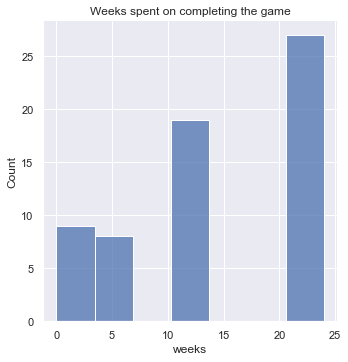

In [52]:
sns.displot(data=df_resist.groupby('player_id').max()['weeks'])
plt.title("Weeks spent on completing the game");

We can see there are 3 groups of players:

- 0-10 weeks
- 10-15 weeks
- 20-25 weeks

How do players' drug resistance change over time for each group?

In [161]:
# 0-5 weeks
player_list_0_5 = df_resist.groupby('player_id').max().query("weeks < 10").index
# 10-15 weeks
player_list_10_15 = df_resist.groupby('player_id').max().query("10 <= weeks < 15").index
# 20-25 weeks
player_list_20_25 = df_resist.groupby('player_id').max().query("20 <= weeks <= 25").index

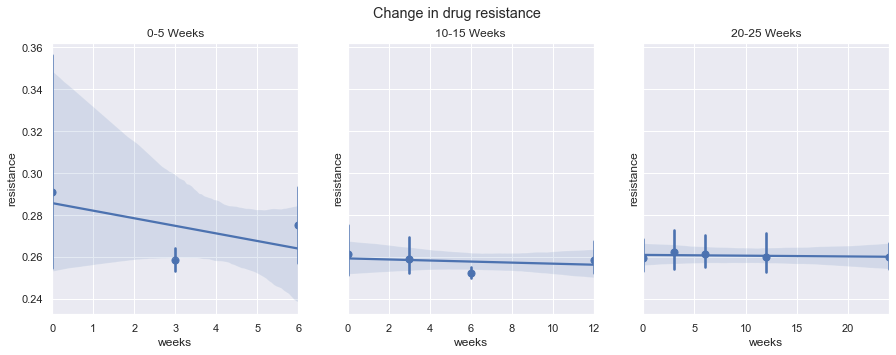

In [93]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(15, 5))

fig.suptitle('Change in drug resistance')
axes[0].set_title('0-5 Weeks')
axes[1].set_title('10-15 Weeks')
axes[2].set_title('20-25 Weeks')

sns.regplot(ax=axes[0], x='weeks', y='resistance', data=df_resist.where(df_resist['player_id'].isin(player_list_0_5)), x_estimator=np.mean)
sns.regplot(ax=axes[1], x='weeks', y='resistance', data=df_resist.where(df_resist['player_id'].isin(player_list_10_15)), x_estimator=np.mean)
sns.regplot(ax=axes[2], x='weeks', y='resistance', data=df_resist.where(df_resist['player_id'].isin(player_list_20_25)), x_estimator=np.mean);

It looks like on average, players who spent the least time completing the game experienced steeper decreases in drug resistance ratings.

***Potential research question: is drug resistance rating associated with playing time in some way?***

Moving on to the main dataset, `logs.csv`

In [ ]:
df_log = pd.read_csv("data files/logs.csv", low_memory=False)

This dataset is large, so let's focus on just one player first.

In [8]:
player_a = df_log['player_id'][0]
df_player_a = df_log.query(f"player_id == {player_a}")

This game is divided into 12 scenes ("stacks"). Each with a different theme. See `Spreadsheets\ChallengeStacksData.xlsx` for details on each stack.

In [104]:
# keys are stack ids, values are stack themes
stacks = {
    0: "Cheaters",
    1: "Poolside",
    2: "Kissing",
    3: "Pills",
    4: "Misbehavin'",
    5: "New Year's",
    6: "Serious",
    7: "Racing",
    8: "Scare",
    9: "Prom",
    10: "Confide",
    11: "First Job",
    12: "Tutorial"
}

How long does this player spend on each stack? We can write a function for this:

In [177]:
def stack_play_time(player_id):
    df_player = df_log.query(f"player_id == {player_id}")
    play_history = df_player.dropna(subset=['stack_id'])[['stack_id', 'event_time_dbl']].groupby('stack_id').max()
    # need to sort by event_time_dbl because players don't necessarily go through stacks in numerical order
    play_history.sort_values(by='event_time_dbl', inplace=True)
    play_times = play_history.diff()
    play_times.rename(columns={'event_time_dbl': 'play_time'}, inplace=True)
    # we don't care about the tutorial
    play_times.drop(index=12, inplace=True)
    play_times.sort_index(inplace=True)
    play_times['description'] = [stacks[x] for x in play_times.index]
    play_times['player_id'] = player_id
    play_times = play_times[['player_id', 'play_time', 'description']]
    play_times.reset_index(inplace=True)
    play_times['stack_id'] = play_times['stack_id'].astype(int)
    return play_times

In [178]:
stack_play_time(player_a)

,stack_id,player_id,play_time,description
0,0,6427001,3835.0,Cheaters
1,1,6427001,1588.0,Poolside
2,2,6427001,2402.0,Kissing
3,3,6427001,1388.0,Pills
4,4,6427001,1867.0,Misbehavin'
5,5,6427001,3045.0,New Year's
6,6,6427001,2972.0,Serious
7,7,6427001,1925.0,Racing
8,8,6427001,2809.0,Scare
9,9,6427001,1025.0,Prom


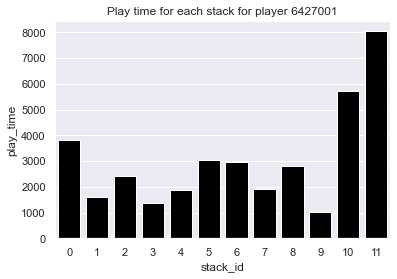

In [179]:
sns.barplot(x='stack_id', y='play_time', data=stack_play_time(player_a), color='black')
plt.title(f"Play time for each stack for player {player_a}");

Now, let's take a look at this metric on an aggregate level.

In [181]:
df_play_time = pd.concat([stack_play_time(player) for player in df_log['player_id'].unique()])

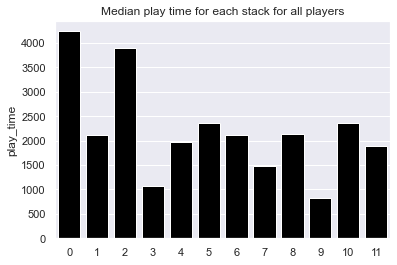

In [204]:
sns.barplot(x=np.arange(12), y='play_time', data=df_play_time.groupby('stack_id').median(), color='black')
plt.title("Median play time for each stack for all players");

## 2. Statistical Model

## 3. Conclusion